<a href="https://colab.research.google.com/github/merajsiddieque/DS-LAB/blob/main/DS_Lab3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the repo
!git clone https://github.com/alpha-13/Face-Recognition.git



Cloning into 'Face-Recognition'...
remote: Enumerating objects: 686, done.
remote: Total 686 (delta 0), reused 0 (delta 0), pack-reused 686 (from 1)
Receiving objects: 100% (686/686), 10.33 MiB | 25.00 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!apt-get install -y imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10
  libwmflite-0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fon

In [3]:
!find /content/Face-Recognition/Datasets -name "*.pgm" -exec sh -c 'convert "$1" "${1%.pgm}.png" && rm "$1"' _ {} \;

In [ ]:
from google.colab import files
import shutil

# Create a zip file
shutil.make_archive("/content/Face-Recognition", 'zip', "/content/Face-Recognition")

# Download zip
files.download("/content/Face-Recognition.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 1

In [4]:
import os
import cv2
import numpy as np

# Paths
train_path = "/content/Face-Recognition/Datasets/att_faces/Training"
test_path  = "/content/Face-Recognition/Datasets/att_faces/Testing"

# Function to load images + labels
def load_dataset(base_path):
    images = []
    labels = []
    for person_folder in sorted(os.listdir(base_path)):
        person_path = os.path.join(base_path, person_folder)
        if os.path.isdir(person_path):  # only consider subject folders
            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img.flatten())   # flatten 112x92 → 10304 vector
                    labels.append(person_folder)   # keep "s1", "s2", ...
    return np.array(images), np.array(labels)

# Load training and testing sets
X_train, y_train = load_dataset(train_path)
X_test, y_test   = load_dataset(test_path)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set :", X_test.shape, y_test.shape)

print("Subjects in training:", np.unique(y_train))
print("Subjects in testing :", np.unique(y_test))


Training set: (360, 10304) (360,)
Testing set : (40, 10304) (40,)
Subjects in training: ['s1' 's10' 's11' 's12' 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's2'
 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's28' 's29' 's3' 's30'
 's31' 's32' 's33' 's34' 's35' 's36' 's37' 's38' 's39' 's4' 's40' 's5'
 's6' 's7' 's8' 's9']
Subjects in testing : ['s1' 's10' 's11' 's12' 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's2'
 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's28' 's29' 's3' 's30'
 's31' 's32' 's33' 's34' 's35' 's36' 's37' 's38' 's39' 's4' 's40' 's5'
 's6' 's7' 's8' 's9']


In [5]:
from sklearn.preprocessing import StandardScaler

# Standardize data (zero mean, unit variance)
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)  # fit on training set, transform train
X_test_std  = scaler.transform(X_test)       # transform test set using same scaler

print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape :", X_test_std.shape)
print("Mean (should be ~0):", np.mean(X_train_std))
print("Std (should be ~1):", np.std(X_train_std))


X_train_std shape: (360, 10304)
X_test_std shape : (40, 10304)
Mean (should be ~0): 1.0849384422837969e-17
Std (should be ~1): 0.9999999999999998


# 2

In [6]:
# Shapes: X_train_std = (360, 10304)
n_samples = X_train_std.shape[0]

# Compute covariance matrix manually
cov_matrix = (X_train_std.T @ X_train_std) / (n_samples - 1)

print("Covariance matrix shape:", cov_matrix.shape)


Covariance matrix shape: (10304, 10304)


In [ ]:
import numpy as np

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(cov_matrix)  # symmetric covariance

print("Number of eigenvalues:", eigvals.shape[0])
print("Eigenvalues (first 5):", eigvals[:5])
print("Eigenvectors shape:", eigvecs.shape)

In [ ]:
import numpy as np

idx_desc = np.argsort(eigvals)[::-1]           # indices of sorted eigenvalues (largest first)
eigvals_sorted = eigvals[idx_desc]             # sorted eigenvalues
eigvecs_sorted = eigvecs[:, idx_desc]          # corresponding eigenvectors sorted

# 3) Display info
print("Shape of eigenvectors matrix:", eigvecs_sorted.shape)
print("Top 5 eigenvalues:", eigvals_sorted[:5])


In [ ]:
# Assume eigvecs_sorted and eigvals_sorted are already computed and sorted

k = 200  # number of principal components you want to keep

# Select top-k eigenvectors (principal components / eigenfaces)
eigenfaces = eigvecs_sorted[:, :k]  # shape: (n_features, k)
top_eigenvalues = eigvals_sorted[:k]  # optional: top-k eigenvalues

print("Shape of selected eigenfaces:", eigenfaces.shape)
print("Top-k eigenvalues:", top_eigenvalues[:5])  # preview first 5


#3

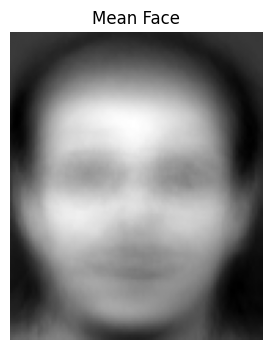

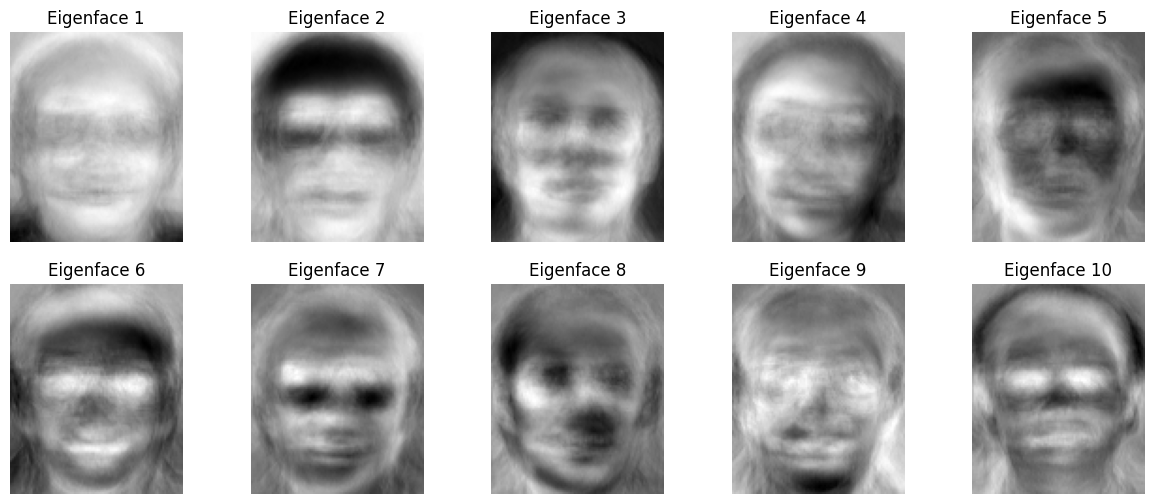

In [11]:
import matplotlib.pyplot as plt

# Mean face
X_mean = np.mean(X_train, axis=0)
mean_face_img = X_mean.reshape(112, 92)

plt.figure(figsize=(4,4))
plt.imshow(mean_face_img, cmap="gray")
plt.title("Mean Face")
plt.axis("off")
plt.show()

# First 10 Eigenfaces
n_eigenfaces = 10
plt.figure(figsize=(15, 6))
for i in range(n_eigenfaces):
    eigenface_img = eigfaces[:, i].reshape(112, 92)
    plt.subplot(2, 5, i+1)
    plt.imshow(eigenface_img, cmap="gray")
    plt.title(f"Eigenface {i+1}")
    plt.axis("off")
plt.show()


#4

In [ ]:
# Function to project data into PCA space
def project_data(X, eigfaces, k):
    """ Project data X into PCA space using top k eigenfaces """
    return np.dot(X, eigfaces[:, :k])

# Try different values of k
k_values = [10, 50, 100, 200, 300, 350]

for k in k_values:
    X_train_pca = project_data(X_train_std, eigfaces, k)
    X_test_pca  = project_data(X_test_std, eigfaces, k)

    print(f"k = {k}")
    print("  Projected X_train_pca shape:", X_train_pca.shape)
    print("  Projected X_test_pca  shape:", X_test_pca.shape)
    print("-"*40)


k = 10
  Projected X_train_pca shape: (360, 10)
  Projected X_test_pca  shape: (40, 10)
----------------------------------------
k = 50
  Projected X_train_pca shape: (360, 50)
  Projected X_test_pca  shape: (40, 50)
----------------------------------------
k = 100
  Projected X_train_pca shape: (360, 100)
  Projected X_test_pca  shape: (40, 100)
----------------------------------------
k = 200
  Projected X_train_pca shape: (360, 200)
  Projected X_test_pca  shape: (40, 200)
----------------------------------------
k = 300
  Projected X_train_pca shape: (360, 300)
  Projected X_test_pca  shape: (40, 300)
----------------------------------------
k = 350
  Projected X_train_pca shape: (360, 350)
  Projected X_test_pca  shape: (40, 350)
----------------------------------------


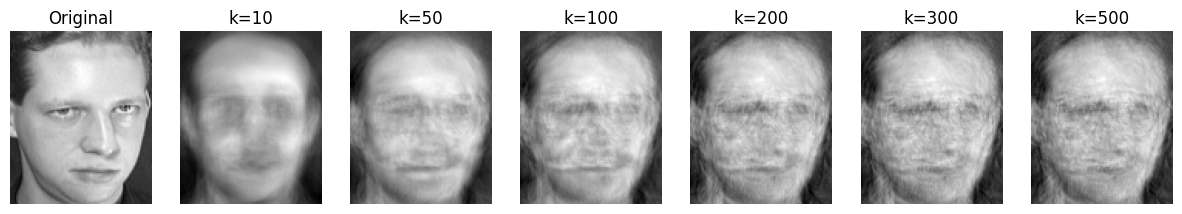

In [22]:
# Function to reconstruct images using top-k eigenfaces (full-covariance)
def reconstruct_clear(X, eigfaces, k, X_mean, test_idx=0):
    """
    Reconstruct a single image from PCA space using top-k eigenfaces.
    X: original data (not standardized)
    eigfaces: full-covariance eigenfaces (d x n_features)
    k: number of top eigenfaces
    X_mean: mean face
    test_idx: index of image to reconstruct
    """
    # Center the image by subtracting mean
    img_centered = X[test_idx] - X_mean

    # Project onto top-k eigenfaces
    coeffs = np.dot(img_centered, eigfaces[:, :k])

    # Reconstruct by adding mean back
    reconstruction = X_mean + np.dot(coeffs, eigfaces[:, :k].T)

    # Reshape to image
    recon_img = reconstruction.reshape(112, 92)
    return recon_img

# Choose test image index
test_idx = 0
original = X_test[test_idx].reshape(112, 92)

# Try different k values
k_values = [10, 50, 100, 200, 300, 500]

plt.figure(figsize=(15, 5))
plt.subplot(1, len(k_values)+1, 1)
plt.imshow(original, cmap="gray")
plt.title("Original")
plt.axis("off")

for i, k in enumerate(k_values):
    recon_img = reconstruct_clear(X_test, eigfaces, k, X_mean, test_idx)
    plt.subplot(1, len(k_values)+1, i+2)
    plt.imshow(recon_img, cmap="gray")
    plt.title(f"k={k}")
    plt.axis("off")

plt.show()


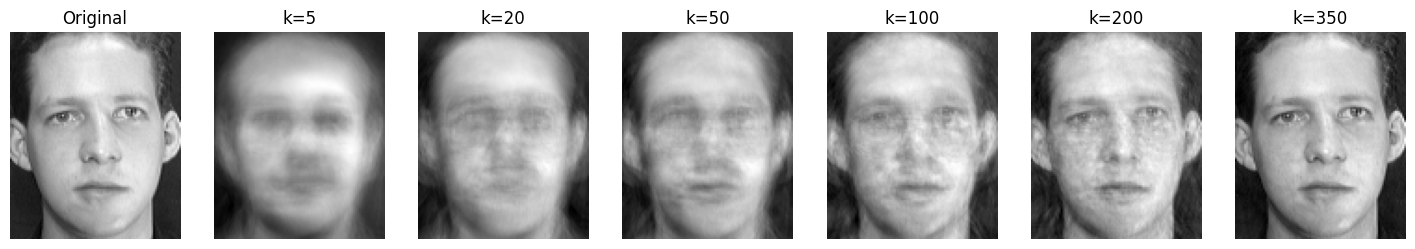

In [24]:
import matplotlib.pyplot as plt

# Reconstruct a sample image with increasing k
sample_idx = 0  # index of image to reconstruct
original_img = X_train[sample_idx].reshape(112, 92)

k_values = [5, 20, 50, 100, 200, 350]

plt.figure(figsize=(18, 4))
plt.subplot(1, len(k_values)+1, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original")
plt.axis("off")

for i, k in enumerate(k_values):
    # Project image onto top-k eigenfaces
    top_eigfaces = eigfaces[:, :k]
    X_mean = np.mean(X_train, axis=0)
    img_centered = X_train[sample_idx] - X_mean
    coeffs = img_centered @ top_eigfaces  # projection
    reconstruction = X_mean + coeffs @ top_eigfaces.T

    plt.subplot(1, len(k_values)+1, i+2)
    plt.imshow(reconstruction.reshape(112, 92), cmap="gray")
    plt.title(f"k={k}")
    plt.axis("off")

plt.show()


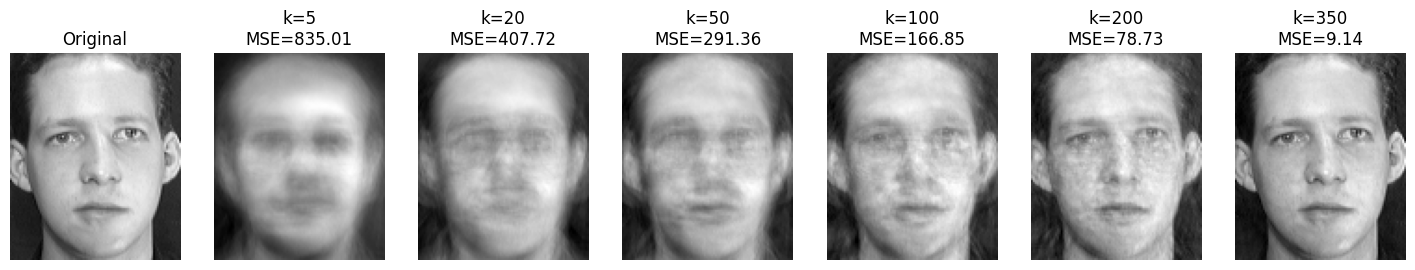

k=5 -> Reconstruction MSE: 835.0084
k=20 -> Reconstruction MSE: 407.7154
k=50 -> Reconstruction MSE: 291.3617
k=100 -> Reconstruction MSE: 166.8508
k=200 -> Reconstruction MSE: 78.7302
k=350 -> Reconstruction MSE: 9.1403


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct a sample image with increasing k
sample_idx = 0  # index of image to reconstruct
original_img = X_train[sample_idx].reshape(112, 92)

k_values = [5, 20, 50, 100, 200, 350]
reconstruction_errors = []  # to store MSE for each k

plt.figure(figsize=(18, 4))
plt.subplot(1, len(k_values)+1, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original")
plt.axis("off")

X_mean = np.mean(X_train, axis=0)  # compute mean face once

for i, k in enumerate(k_values):
    # Project image onto top-k eigenfaces
    top_eigfaces = eigfaces[:, :k]
    img_centered = X_train[sample_idx] - X_mean
    coeffs = img_centered @ top_eigfaces  # projection
    reconstruction = X_mean + coeffs @ top_eigfaces.T

    # Compute reconstruction error (MSE)
    mse = np.mean((X_train[sample_idx] - reconstruction) ** 2)
    reconstruction_errors.append(mse)

    plt.subplot(1, len(k_values)+1, i+2)
    plt.imshow(reconstruction.reshape(112, 92), cmap="gray")
    plt.title(f"k={k}\nMSE={mse:.2f}")
    plt.axis("off")

plt.show()

# Print reconstruction errors
for k, mse in zip(k_values, reconstruction_errors):
    print(f"k={k} -> Reconstruction MSE: {mse:.4f}")


k=10  -> avg MSE = 674.5095
k=50  -> avg MSE = 406.2459
k=100  -> avg MSE = 335.9017
k=200  -> avg MSE = 286.0017
k=300  -> avg MSE = 262.3477
k=350  -> avg MSE = 254.0375


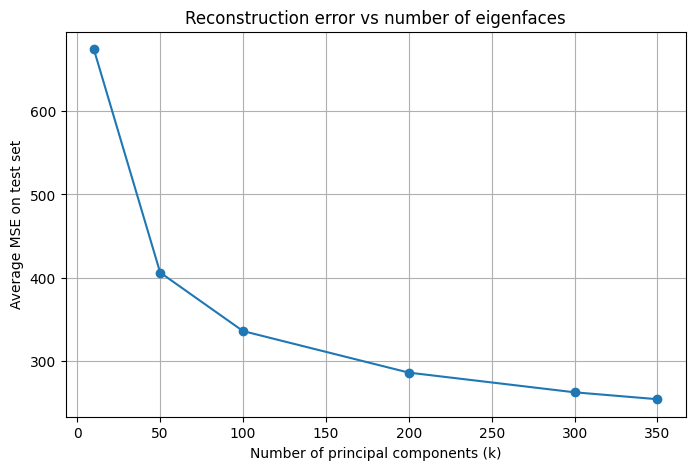

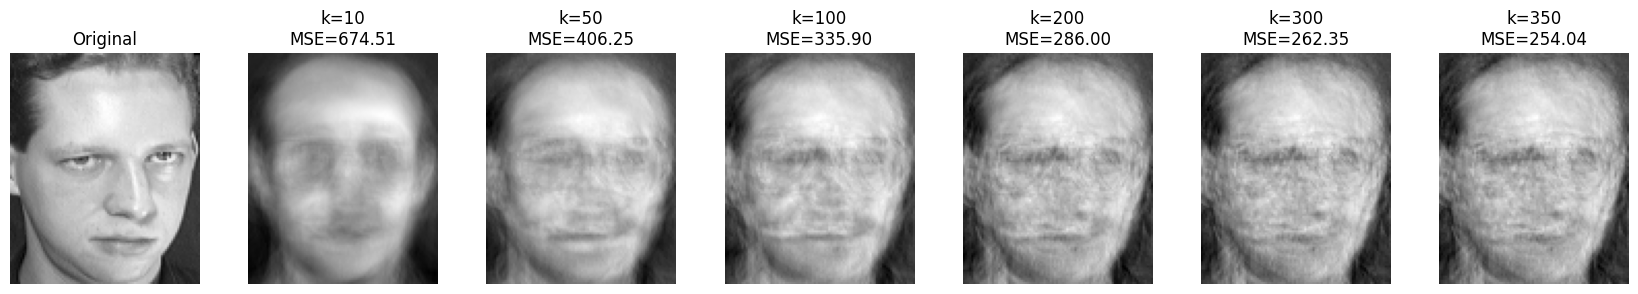

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k_values = [10, 50, 100, 200, 300, 350]   # number of eigenfaces to try
test_idx = 0                               # test image index
H, W = 112, 92                             # image dimensions

# Make sure X_mean is the mean of original X_train (not standardized)
X_mean_vec = X_mean.copy()                 # shape (d,)

avg_mse_list = []
all_recons_for_viz = []

# Center the test set
X_test_centered = X_test - X_mean_vec      # subtract mean face

for k in k_values:
    # Project onto top-k eigenfaces
    X_test_pca_k = np.dot(X_test_centered, eigfaces[:, :k])      # shape (n_test, k)

    # Reconstruct from PCA space
    X_test_recon_k = np.dot(X_test_pca_k, eigfaces[:, :k].T) + X_mean_vec  # shape (n_test, d)

    # Compute MSE per image
    mses = np.mean((X_test - X_test_recon_k) ** 2, axis=1)
    avg_mse = np.mean(mses)
    avg_mse_list.append(avg_mse)

    # Save reconstruction of the chosen test image
    all_recons_for_viz.append(X_test_recon_k[test_idx].reshape(H, W))

    print(f"k={k}  -> avg MSE = {avg_mse:.4f}")

# Plot Average MSE vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, avg_mse_list, marker='o')
plt.xlabel("Number of principal components (k)")
plt.ylabel("Average MSE on test set")
plt.title("Reconstruction error vs number of eigenfaces")
plt.grid(True)
plt.show()

# Visualize original + reconstructions
plt.figure(figsize=(3*(len(k_values)+1), 3))
# Original
plt.subplot(1, len(k_values)+1, 1)
plt.imshow(X_test[test_idx].reshape(H, W), cmap='gray')
plt.title("Original")
plt.axis('off')

# Reconstructions
for i, k in enumerate(k_values):
    plt.subplot(1, len(k_values)+1, i+2)
    plt.imshow(all_recons_for_viz[i], cmap='gray')
    plt.title(f"k={k}\nMSE={avg_mse_list[i]:.2f}")
    plt.axis('off')
plt.show()


#5

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Choose number of eigenfaces (k)
k = 350

# Center training and test data using mean face
X_train_centered = X_train - X_mean       # shape (n_train, d)
X_test_centered  = X_test  - X_mean       # shape (n_test, d)

# Project onto top-k eigenfaces
X_train_pca = np.dot(X_train_centered, eigfaces[:, :k])  # (n_train, k)
X_test_pca  = np.dot(X_test_centered,  eigfaces[:, :k])  # (n_test, k)

# Train 1-NN classifier
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Compute accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Recognition accuracy with k={k} eigenfaces: {acc*100:.2f}%")


Recognition accuracy with k=350 eigenfaces: 92.50%


k=10 -> Accuracy: 92.50%
k=50 -> Accuracy: 95.00%
k=100 -> Accuracy: 95.00%
k=200 -> Accuracy: 92.50%
k=300 -> Accuracy: 92.50%
k=350 -> Accuracy: 92.50%


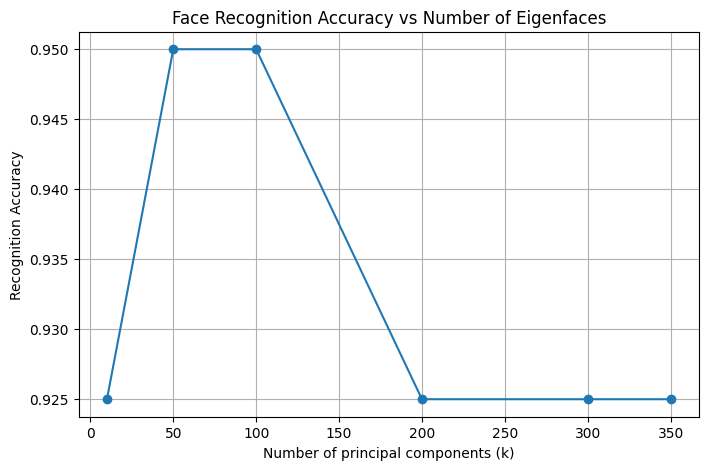

In [31]:
k_values = [10, 50, 100, 200, 300, 350]
acc_list = []

# Center the original data using mean face
X_train_centered = X_train - X_mean
X_test_centered  = X_test  - X_mean

for k in k_values:
    # Project into PCA space
    X_train_pca = np.dot(X_train_centered, eigfaces[:, :k])
    X_test_pca  = np.dot(X_test_centered,  eigfaces[:, :k])

    # Train 1-NN classifier
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_train_pca, y_train)

    # Predict & evaluate
    y_pred = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

    print(f"k={k} -> Accuracy: {acc*100:.2f}%")

# Plot accuracy vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, acc_list, marker='o')
plt.xlabel("Number of principal components (k)")
plt.ylabel("Recognition Accuracy")
plt.title("Face Recognition Accuracy vs Number of Eigenfaces")
plt.grid(True)
plt.show()


#5

In [32]:
# Pick number of eigenfaces (k)
k = 350

# Project into PCA space
X_train_pca = np.dot(X_train_std, eigfaces[:, :k])   # (n_train, k)
X_test_pca  = np.dot(X_test_std,  eigfaces[:, :k])   # (n_test, k)


In [33]:
def nearest_neighbor_classifier(X_train, y_train, X_test):
    """
    Predict labels for X_test using 1-NN on X_train.
    Distance: Euclidean
    """
    y_pred = []
    for test_sample in X_test:
        # Compute distances to all training samples
        dists = np.linalg.norm(X_train - test_sample, axis=1)
        # Find nearest neighbor
        nn_index = np.argmin(dists)
        # Assign label of nearest neighbor
        y_pred.append(y_train[nn_index])
    return np.array(y_pred)


In [34]:
# Run NN classifier
y_pred = nearest_neighbor_classifier(X_train_pca, y_train, X_test_pca)

# Compute accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Nearest Neighbor (1-NN) Accuracy with k={k}: {accuracy*100:.2f}%")


Nearest Neighbor (1-NN) Accuracy with k=350: 92.50%


k= 10 → Accuracy: 95.00%
k= 20 → Accuracy: 95.00%
k= 50 → Accuracy: 95.00%
k=100 → Accuracy: 95.00%
k=150 → Accuracy: 92.50%
k=200 → Accuracy: 90.00%


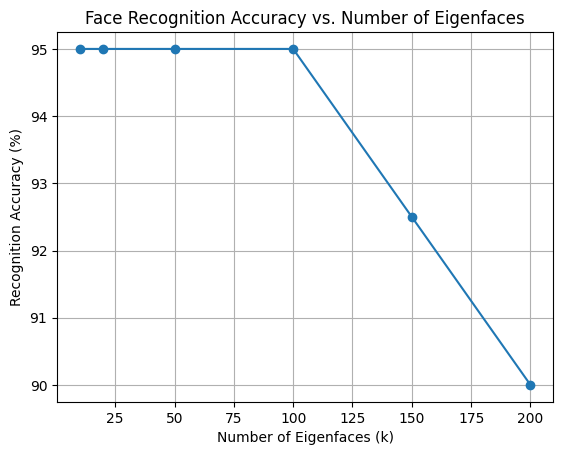

In [35]:
# Different k values to test
k_values = [10, 20, 50, 100, 150, 200]

accuracies = []

for k in k_values:
    # Project into PCA space with top-k eigenfaces
    X_train_pca = np.dot(X_train_std, eigfaces[:, :k])
    X_test_pca  = np.dot(X_test_std,  eigfaces[:, :k])

    # Run nearest neighbor classifier
    y_pred = nearest_neighbor_classifier(X_train_pca, y_train, X_test_pca)

    # Compute accuracy
    acc = np.mean(y_pred == y_test)
    accuracies.append(acc)
    print(f"k={k:3d} → Accuracy: {acc*100:.2f}%")

# Optional: Plot accuracy vs k
import matplotlib.pyplot as plt

plt.plot(k_values, np.array(accuracies)*100, marker='o')
plt.xlabel("Number of Eigenfaces (k)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Face Recognition Accuracy vs. Number of Eigenfaces")
plt.grid(True)
plt.show()


#6

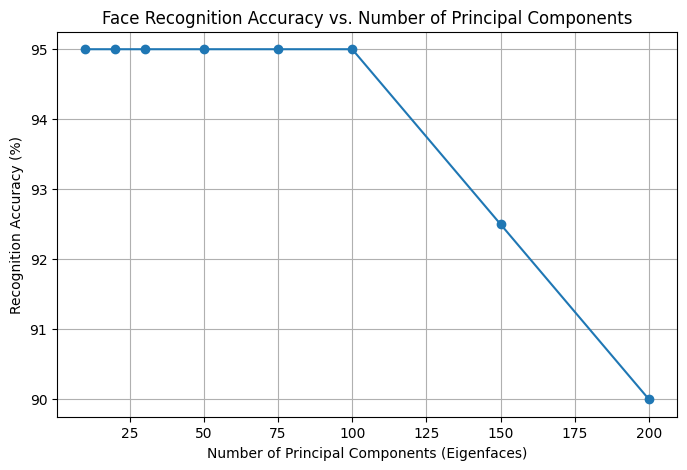

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Values of k to test
k_values = [10, 20, 30, 50, 75, 100, 150, 200]

accuracies = []

for k in k_values:
    # Project into PCA space with top-k eigenfaces
    X_train_pca = np.dot(X_train_std, eigfaces[:, :k])
    X_test_pca  = np.dot(X_test_std,  eigfaces[:, :k])

    # Predict with nearest neighbor
    y_pred = nearest_neighbor_classifier(X_train_pca, y_train, X_test_pca)

    # Compute accuracy
    acc = np.mean(y_pred == y_test)
    accuracies.append(acc)

# Plot accuracy vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, np.array(accuracies)*100, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components (Eigenfaces)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Face Recognition Accuracy vs. Number of Principal Components")
plt.grid(True)
plt.show()


# ***Bonus Task***

In [37]:
k_tsne = 50
W_tsne = eigenfaces[:, :k_tsne]   # (10304, 50)
X_train_pca_tsne = X_train_std @ W_tsne   # (360, 50)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


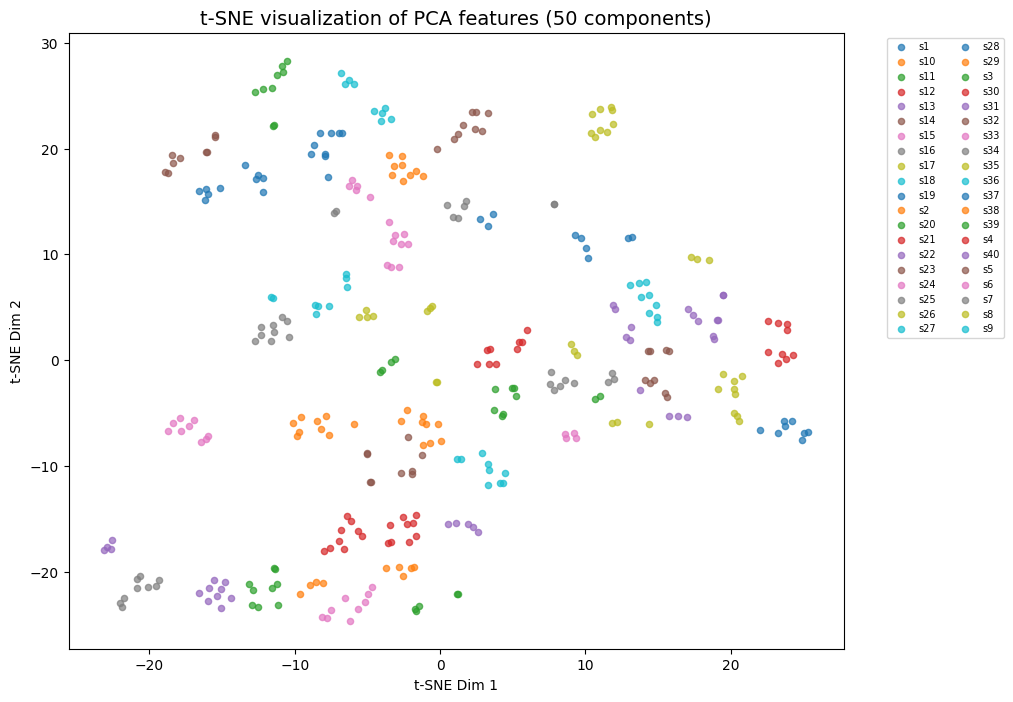

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use eigenfaces instead of eigvecs_sorted (make sure you computed them earlier)
k_tsne = 50
W_tsne = eigenfaces[:, :k_tsne]          # (10304, 50)
X_train_pca_tsne = X_train_std @ W_tsne  # (360, 50)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_pca_tsne)

# Plot
plt.figure(figsize=(10, 8))
for subject in np.unique(y_train):
    idx = np.where(y_train == subject)[0]
    plt.scatter(X_train_tsne[idx, 0], X_train_tsne[idx, 1], label=subject, s=20, alpha=0.7)

plt.title("t-SNE visualization of PCA features (50 components)", fontsize=14)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, ncol=2)
plt.show()


2D

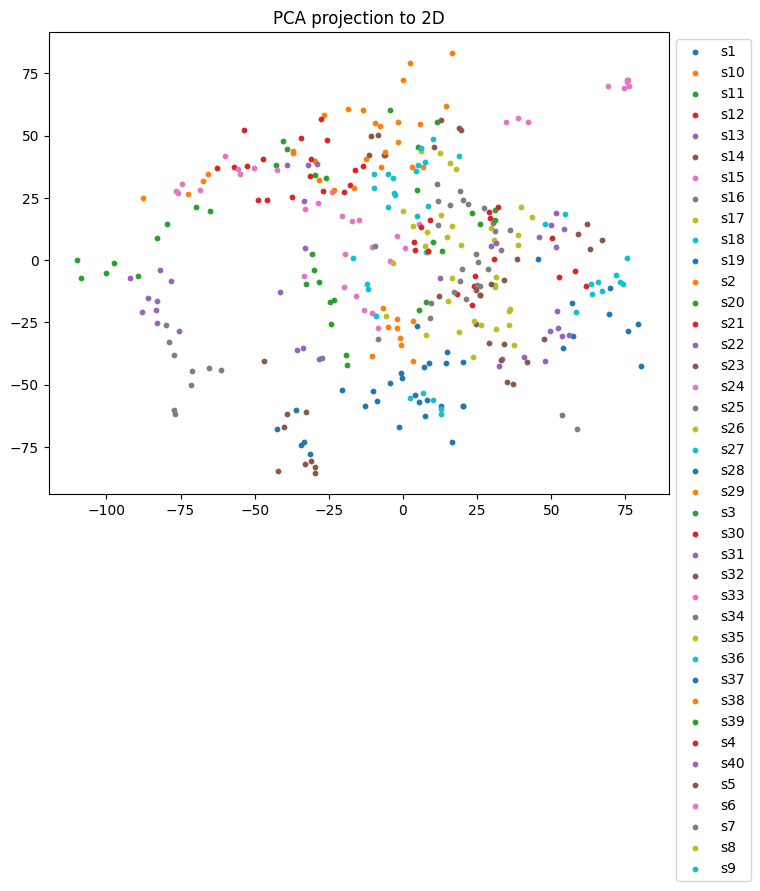

In [39]:
# Reduce to 2D with PCA
W_2d = eigenfaces[:, :2]                 # top 2 eigenfaces
X_train_pca_2d = X_train_std @ W_2d      # project into 2D

plt.figure(figsize=(8,6))
for subject in np.unique(y_train):
    idx = np.where(y_train == subject)[0]
    plt.scatter(X_train_pca_2d[idx,0], X_train_pca_2d[idx,1], s=10, label=subject)
plt.title("PCA projection to 2D")
plt.legend(bbox_to_anchor=(1,1))
plt.show()


# 3D

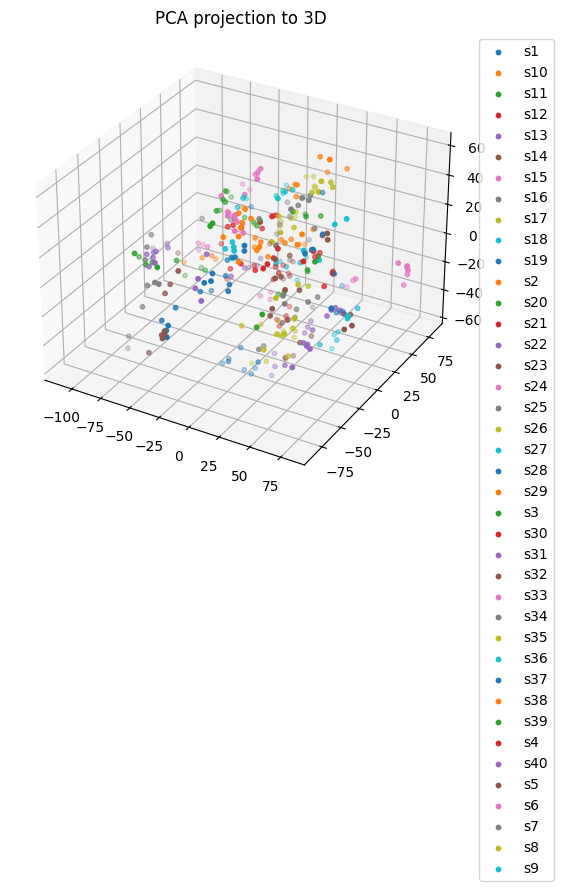

In [40]:
from mpl_toolkits.mplot3d import Axes3D

W_3d = eigenfaces[:, :3]                 # top 3 eigenfaces
X_train_pca_3d = X_train_std @ W_3d

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for subject in np.unique(y_train):
    idx = np.where(y_train == subject)[0]
    ax.scatter(X_train_pca_3d[idx,0], X_train_pca_3d[idx,1], X_train_pca_3d[idx,2], s=10, label=subject)
ax.set_title("PCA projection to 3D")
plt.legend(bbox_to_anchor=(1,1))
plt.show()


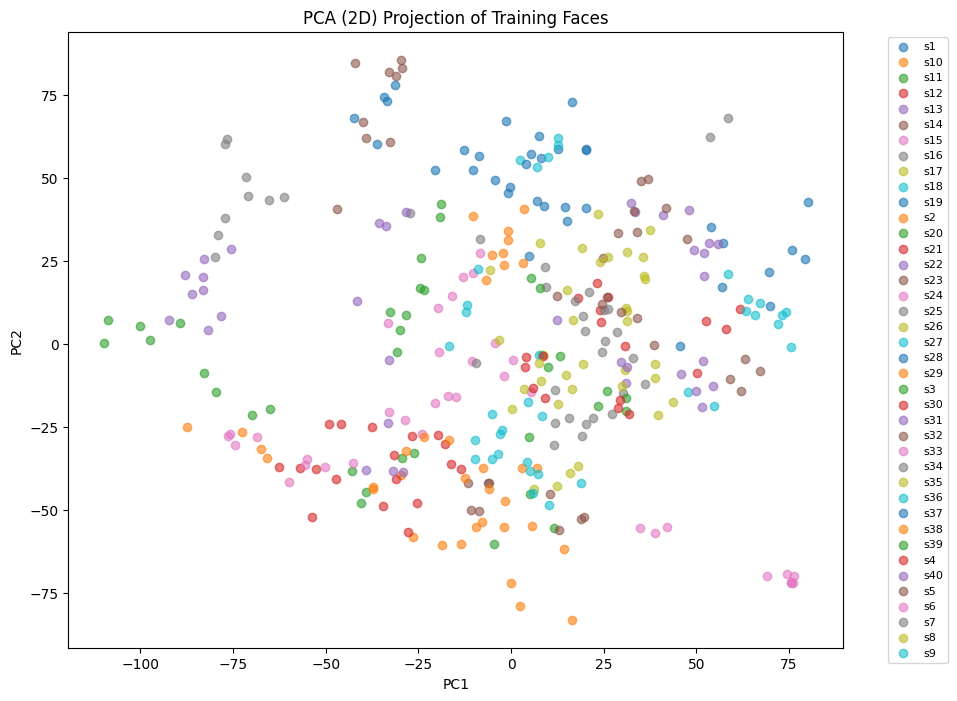

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_std)

# Plot clusters
plt.figure(figsize=(10, 8))
for subj in np.unique(y_train):
    idx = np.where(y_train == subj)
    plt.scatter(X_train_pca_2d[idx, 0], X_train_pca_2d[idx, 1], label=subj, alpha=0.6)

plt.title("PCA (2D) Projection of Training Faces")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()
